# Predicting Lipophilicity in molecules

##Introduction

Lipophilicity is a physicochemical property of crucial importance in medicinal chemistry. On the molecular level it encodes information on the network of inter- and intramolecular forces affecting drug transport through lipid structures as well as drug's interactions with the target protein. In result, on the organism level, lipophilicity is an important factor defining pharmacokinetics and pharmacodynamics of a drug substance. Thus, it is a meaningful parameter that found innumerable applications in drug development, Quantitative Structure-Activity Relationships (QSARs) and Quantitative Structure-Pharmacokinetic Relationships (QSPkRs) analyses.

It's usually evaluated by a distribution coefficent P - the ratio of concentrations of a particular compound in a mixture of two immiscible phases at equilibrium (water/octanol). The greater P values refer to greater lipophilicity. Usually lipophilicity is presented as log10P like in the dataset used for the analysis.

It takes much time to perform an experiment to measure the corresponding P value, because it must be an exact and reproducible procedure repeated at least 3-5 times and each time you have to wait till the system's equilibrium is reached.

##Installing rdkit package

In [ ]:
!pip install rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.7 MB 1.7 MB/s 


##Importing modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from rdkit.Chem.Draw import IPythonConsole
from sklearn import svm
import pickle
from sklearn.metrics import mean_squared_error

##Loading dataset, view of molecule mol images.

In [ ]:
logP=pd.read_csv('/content/logP_dataset.csv',names=['smiles', 'logP'])
logP.head()

,smiles,logP
0,C[C@H]([C@@H](C)Cl)Cl,2.3
1,C(C=CBr)N,0.3
2,CCC(CO)Br,1.3
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0
4,CCCOCCP,0.6


In [ ]:
logP.shape

(14610, 2)

In [ ]:
logP=logP.dropna()

In [ ]:
logP.shape

(14610, 2)

In [ ]:
#Method transforms smiles strings to mol rdkit object
logP['mol'] = logP['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 

In [ ]:
logP

,smiles,logP,mol
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x7fb48a3ce620>
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x7fb48a3ce7b0>
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x7fb48a3ce760>
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0,<rdkit.Chem.rdchem.Mol object at 0x7fb48a3ce710>
4,CCCOCCP,0.6,<rdkit.Chem.rdchem.Mol object at 0x7fb48a3ce800>
...,...,...,...
14605,CCC(SC)Br,2.7,<rdkit.Chem.rdchem.Mol object at 0x7fb48a2f9ee0>
14606,[2H]C([2H])([C@@H](CO)O)O,-1.8,<rdkit.Chem.rdchem.Mol object at 0x7fb48a2f9f30>
14607,CC(C)NNC,0.4,<rdkit.Chem.rdchem.Mol object at 0x7fb48a2f9f80>
14608,C[C@H]1CCC[CH]1,3.4,<rdkit.Chem.rdchem.Mol object at 0x7fb48a2fa030>


In [ ]:
#Data type
type(logP['mol'][0])

rdkit.Chem.rdchem.Mol

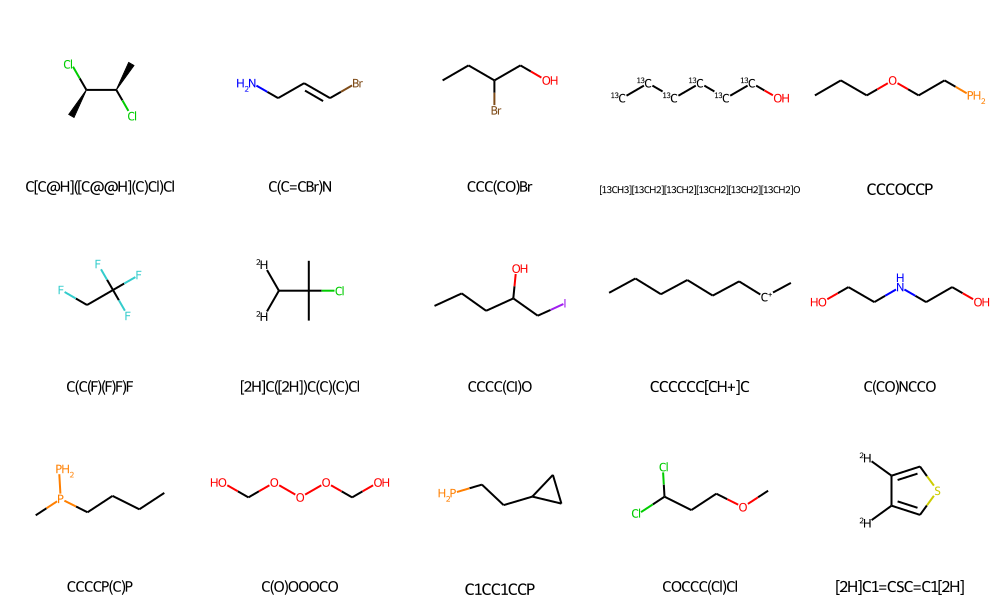

In [ ]:
#Printing out the structure of the first 20 molecules with smile notation id
mol_images=logP.mol[:15]
Draw.MolsToGridImage(mol_images, molsPerRow=5, useSVG=True, legends=list(logP['smiles'][:20]))

##Brief exploratory data analysis

### Adding data to the dataset with the following funcitons of rdkit:

AddHs function adds H atoms to a MOL (as Hs in SMILES are usualy ignored)

 GetNumAtoms() function returns a the nubmer of all atoms in a molecule

GetNumHeavyAtoms() function returns a nubmer of all atoms in a molecule with molecular weight > 1

In [ ]:

logP['mol'] = logP['mol'].apply(lambda x: Chem.AddHs(x))
logP['num_of_atoms'] = logP['mol'].apply(lambda x: x.GetNumAtoms())
logP['num_of_heavy_atoms'] = logP['mol'].apply(lambda x: x.GetNumHeavyAtoms())

In [ ]:
logP.head()

,smiles,logP,mol,num_of_atoms,num_of_heavy_atoms
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x7fb48a1b0da0>,14,6
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x7fb48a1b0bc0>,11,5
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x7fb48a1b0c10>,15,6
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0,<rdkit.Chem.rdchem.Mol object at 0x7fb48a1b88a0>,21,7
4,CCCOCCP,0.6,<rdkit.Chem.rdchem.Mol object at 0x7fb48a1b88f0>,20,7


In [ ]:
#Looking at basic stats of the dataframe
logP.describe()

,logP,num_of_atoms,num_of_heavy_atoms
count,14610.000000,14610.000000,14610.000000
mean,0.998665,14.412594,5.903285
std,1.300486,4.693705,1.113774
min,-3.600000,2.000000,2.000000
25%,0.100000,11.000000,5.000000
50%,1.000000,15.000000,6.000000
75%,1.800000,18.000000,7.000000
max,6.200000,33.000000,11.000000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


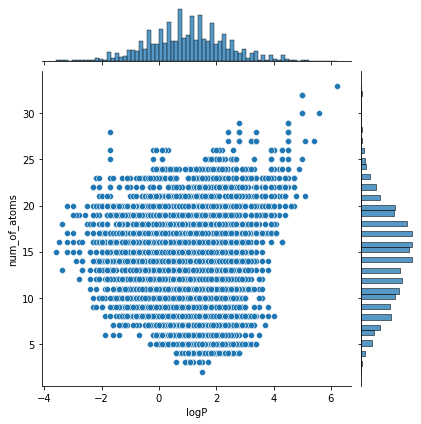

In [ ]:
#Joint plot between 2 variables: number of atoms and logP 
sns.jointplot(logP.logP,logP.num_of_atoms)
sns.set(font_scale=1)
sns.set_style('darkgrid')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


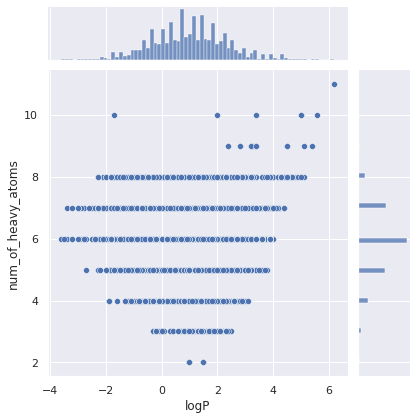

In [ ]:
#Joint plot between 2 variables: number of heavy atoms and logP
sns.jointplot(logP.logP,logP.num_of_heavy_atoms)
sns.set_style('darkgrid')

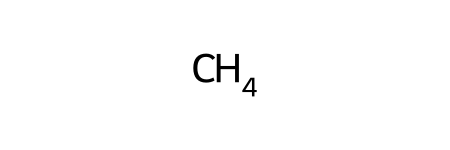

In [ ]:
#Count number of most common atoms present inside the molecules of the entire dataset
c_patt = Chem.MolFromSmiles('C')
c_patt

In [ ]:
logP['mol'][0].GetSubstructMatches(c_patt)
#The method returns a tuple of tuples of positions of corresponding patterns. 
#To extract the number of matches we need to take the length of a corresponding tuple of tuples.

((0,), (1,), (2,), (3,))

In [ ]:
def number_of_atoms(atom_list, data):
    for i in atom_list:
        data['num_of_{}_atoms'.format(i)] = data['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl','P','S'], logP)

In [ ]:
logP

,smiles,logP,mol,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_P_atoms,num_of_S_atoms
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x7fb48a1b0da0>,14,6,4,0,0,2,0,0
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x7fb48a1b0bc0>,11,5,3,0,1,0,0,0
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x7fb48a1b0c10>,15,6,4,1,0,0,0,0
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0,<rdkit.Chem.rdchem.Mol object at 0x7fb48a1b88a0>,21,7,6,1,0,0,0,0
4,CCCOCCP,0.6,<rdkit.Chem.rdchem.Mol object at 0x7fb48a1b88f0>,20,7,5,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
14605,CCC(SC)Br,2.7,<rdkit.Chem.rdchem.Mol object at 0x7fb48885c9e0>,15,6,4,0,0,0,0,1
14606,[2H]C([2H])([C@@H](CO)O)O,-1.8,<rdkit.Chem.rdchem.Mol object at 0x7fb48885ca30>,14,6,3,3,0,0,0,0
14607,CC(C)NNC,0.4,<rdkit.Chem.rdchem.Mol object at 0x7fb48885ca80>,18,6,4,0,2,0,0,0
14608,C[C@H]1CCC[CH]1,3.4,<rdkit.Chem.rdchem.Mol object at 0x7fb48885cad0>,17,6,6,0,0,0,0,0


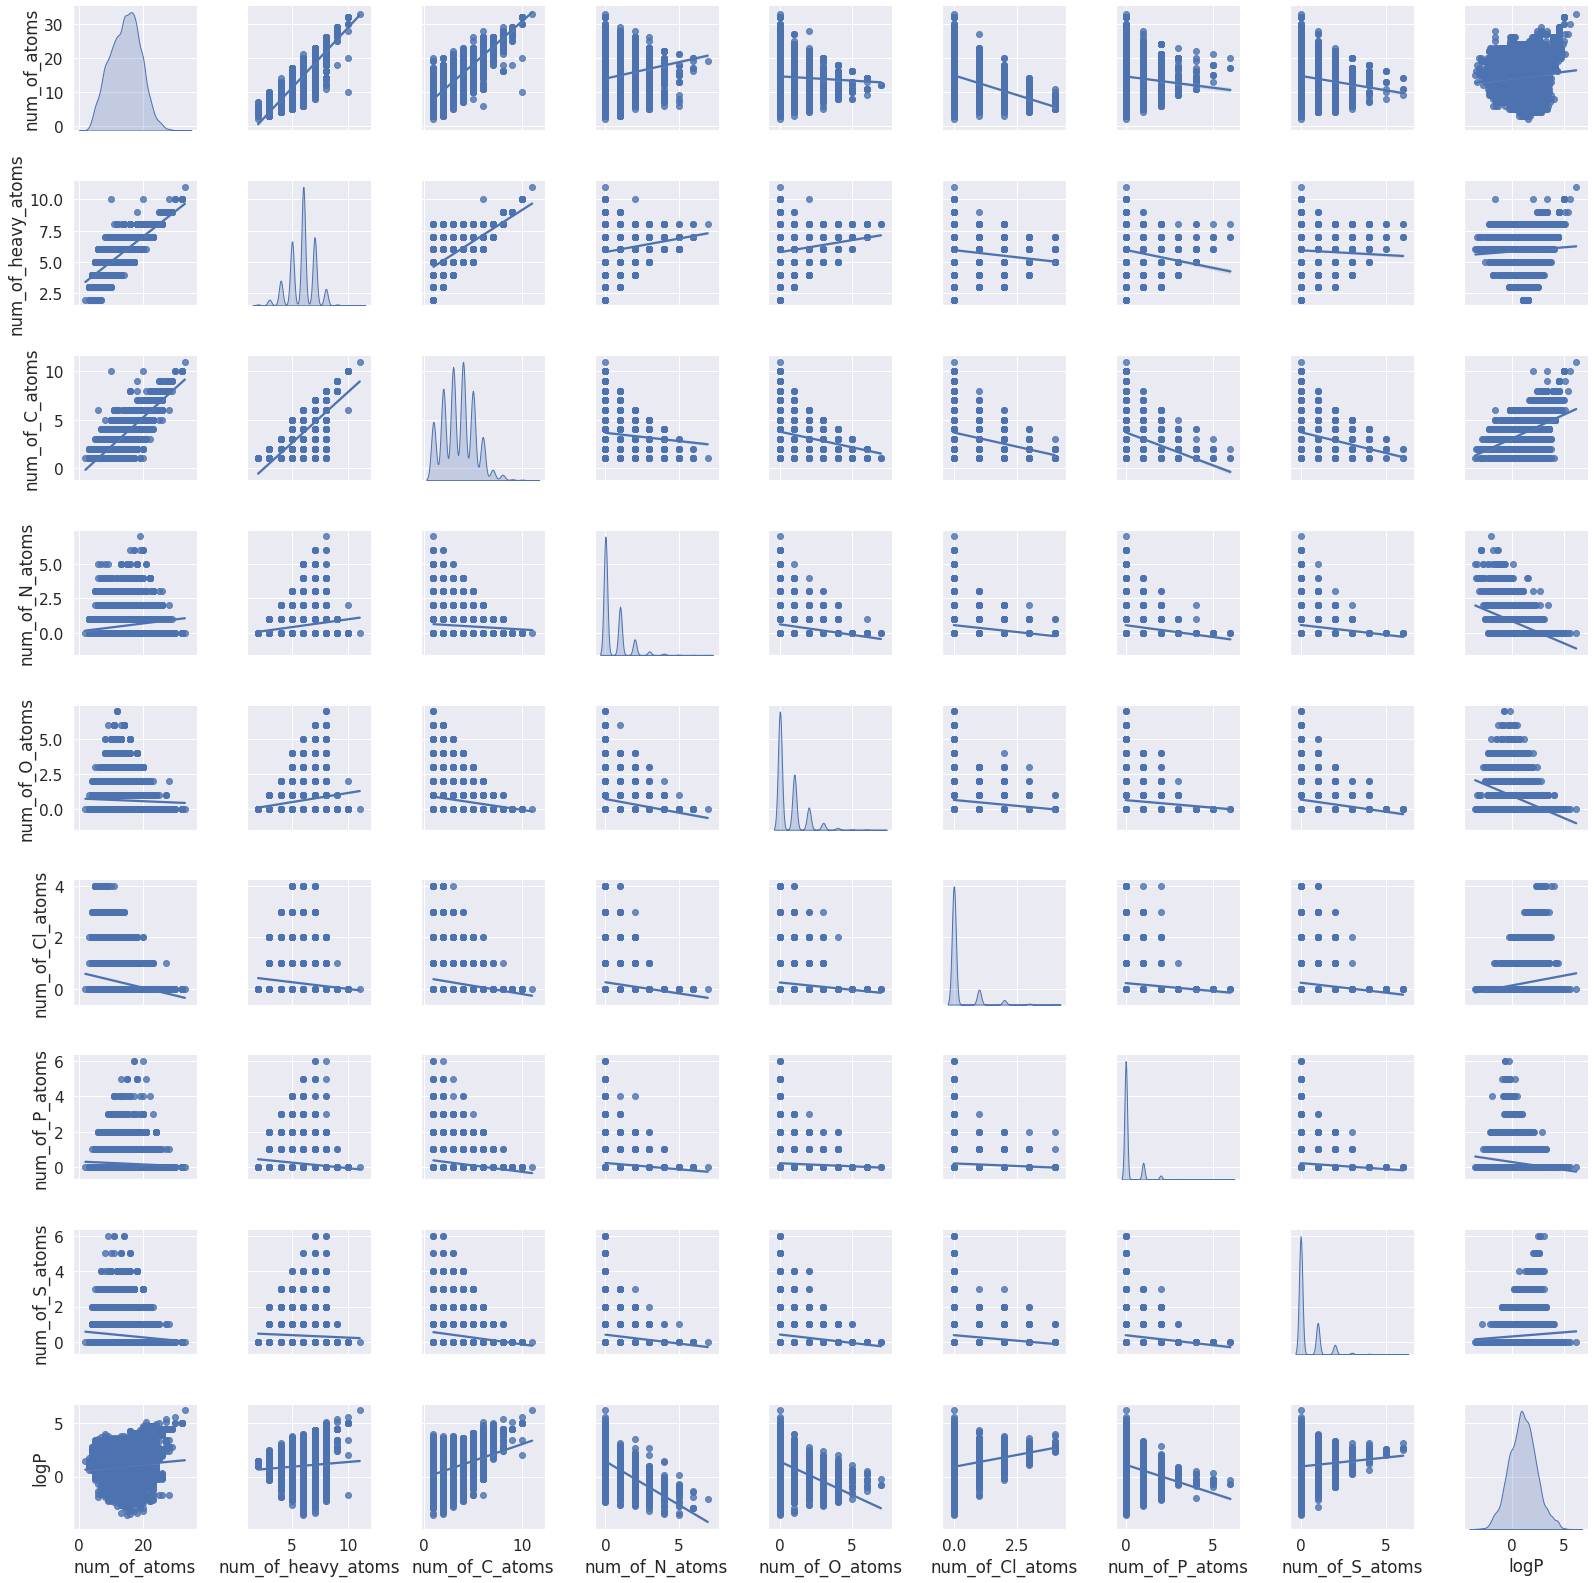

In [ ]:
# Pairplot of the data
sns.set(font_scale=1.4)
sns.pairplot(logP[['num_of_atoms','num_of_heavy_atoms','num_of_C_atoms','num_of_N_atoms', 'num_of_O_atoms','num_of_Cl_atoms','num_of_P_atoms','num_of_S_atoms','logP']],diag_kind='kde',kind='reg')
sns.set_style('darkgrid')
plt.show()

In [ ]:
#correlation table for the data
logP.corr()

,logP,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_P_atoms,num_of_S_atoms
logP,1.000000,0.103265,0.077362,0.394458,-0.442518,-0.508792,0.184074,-0.215927,0.088611
num_of_atoms,0.103265,1.000000,0.846791,0.874478,-0.049033,0.167505,-0.264160,-0.074199,-0.122721
num_of_heavy_atoms,0.077362,0.846791,1.000000,0.730755,0.159259,0.156231,-0.110457,-0.134488,-0.045868
num_of_C_atoms,0.394458,0.874478,0.730755,1.000000,-0.183811,-0.085290,-0.193847,-0.221286,-0.181213
num_of_O_atoms,-0.442518,-0.049033,0.159259,-0.183811,1.000000,-0.171262,-0.098246,-0.061370,-0.127997
num_of_N_atoms,-0.508792,0.167505,0.156231,-0.085290,-0.171262,1.000000,-0.131404,-0.109857,-0.119420
num_of_Cl_atoms,0.184074,-0.264160,-0.110457,-0.193847,-0.098246,-0.131404,1.000000,-0.060324,-0.098376
num_of_P_atoms,-0.215927,-0.074199,-0.134488,-0.221286,-0.061370,-0.109857,-0.060324,1.000000,-0.086568
num_of_S_atoms,0.088611,-0.122721,-0.045868,-0.181213,-0.127997,-0.119420,-0.098376,-0.086568,1.000000


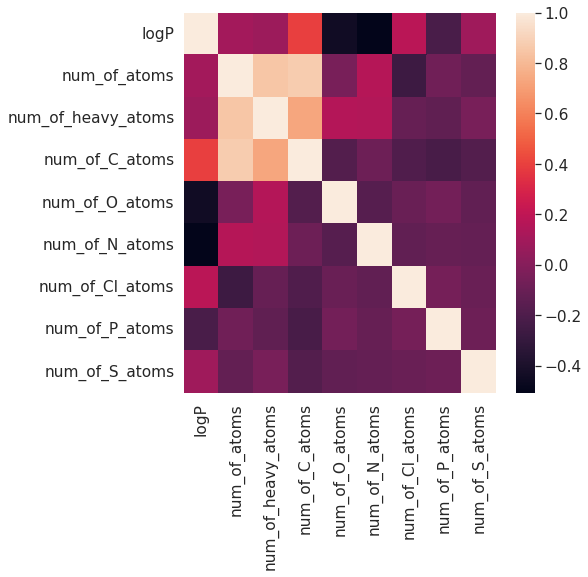

In [ ]:
#making heatmap to see correlation between variables
plt.figure(figsize=(7,7))
sns.heatmap(logP.corr())

- With the heatmap and the pairplot we can see that most of the data variables correlations

- The logP variable(target for our machine learning model) mantains a linear dependence on most of the atoms

- The logP variable has a normal distribution(in pairplot)

##Preparing data for our machine learning model

In [ ]:
#Setting the labels and the target variable
#20% of our data will be used for testing the model and 80% for training it
X=logP.drop(columns=['smiles','mol','logP'])#labels
y=logP['logP']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2)

## Setting up our machine learning model.


In [ ]:
SVR=svm.SVR()
SVR.fit(X_train,y_train)

SVR.score(X_test,y_test)

0.8193619399868621

In [ ]:
predictions_SVR=SVR.predict(X_test)

In [ ]:
mean_squared_error(y_test,predictions_SVR)

0.3141309322279787

In [ ]:
#setting up and fitting the model. Also obtaining accuracy score
#after testing Support vector regressor model and RandomForestRegressor, this second one was the most accurate
rf=RandomForestRegressor()
rf.fit(X_train,y_train)

rf.score(X_test,y_test)

0.8353496705782628

In [ ]:
predictions_rf=rf.predict(X_test)

In [ ]:
mean_squared_error(y_test,predictions_rf)

0.28632814961106395

## Adding more data to the dataset to obtain a more accurate model/prediction. 

rdkit.Chem.Descriptors provides a number of general molecular descriptors that can also be used to featurize a molecule. Most of the descriptors are straightforward to use from Python.

Using this package we can add some useful features to our model:

rdkit.Chem.Descriptors.TPSA() - the surface sum over all polar atoms or molecules also including their attached hydrogen atoms;
rdkit.Chem.Descriptors.ExactMolWt() - exact molecural weight;
rdkit.Chem.Descriptors.NumValenceElectrons() - number of valence electrons (may illustrate general electronic density)
rdkit.Chem.Descriptors.NumHeteroatoms() - general number of non-carbon atoms.

In [ ]:
from rdkit.Chem import Descriptors
logP['tpsa'] = logP['mol'].apply(lambda x: Descriptors.TPSA(x))
logP['mol_w'] = logP['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
logP['num_valence_electrons'] = logP['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
logP['num_heteroatoms'] = logP['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))

In [ ]:
logP.head()

,smiles,logP,mol,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_P_atoms,num_of_S_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x7fb48a1b0da0>,14,6,4,0,0,2,0,0,0.00,126.000306,38,2
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x7fb48a1b0bc0>,11,5,3,0,1,0,0,0,26.02,134.968361,30,2
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x7fb48a1b0c10>,15,6,4,1,0,0,0,0,20.23,151.983677,38,2
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0,<rdkit.Chem.rdchem.Mol object at 0x7fb48a1b88a0>,21,7,6,1,0,0,0,0,20.23,108.124594,44,1
4,CCCOCCP,0.6,<rdkit.Chem.rdchem.Mol object at 0x7fb48a1b88f0>,20,7,5,1,0,0,1,0,9.23,120.070402,44,2


In [ ]:
#check improvement of the model after providing more data to it.
#setting up and fitting the model. Also obtaining accuracy score
#after testing Support vector regressor model and RandomForestRegressor, this second one was the most accurate
X1=logP.drop(columns=['smiles','mol','logP'])#labels
y1=logP['logP']

X1_train,X1_test,y1_train,y1_test=train_test_split(X1,y1,test_size=.2)

SVR1=svm.SVR()
SVR1.fit(X1_train,y1_train)
SVR1.score(X1_test,y1_test)

0.7832349731176785

In [ ]:
predictions_SVR1=SVR1.predict(X1_test)

In [ ]:
mean_squared_error(y1_test,predictions_SVR1)

0.36467251603336776

In [ ]:
#check improvement of the model after providing more data to it.
#setting up and fitting the model. Also obtaining accuracy score
#after testing Support vector regressor model and RandomForestRegressor, this second one was the most accurate
# Prediction accuracy has improved!!!

rf1=RandomForestRegressor()
rf1.fit(X1_train,y1_train)

rf1.score(X1_test,y1_test)

0.9064268721241314

In [ ]:
pickle.dump(rf1,open('def_rf_model.pkl', 'wb'))

## Make a dataframe with the result of the predictions

In [ ]:
y1_test

640      3.5
12526   -0.8
1685     2.9
14262   -0.9
1260     1.0
        ... 
14200    0.9
8992     1.1
13204    0.4
7650     1.6
4207     1.4
Name: logP, Length: 2922, dtype: float64

In [ ]:
X1_test.head()

,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_P_atoms,num_of_S_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms
640,9,5,2,0,2,0,0,1,24.72,88.009519,28,3
12526,12,5,2,0,2,0,1,0,29.03,90.034685,30,3
1685,18,7,5,0,0,1,0,1,0.00,138.026999,44,2
14262,13,5,1,0,0,0,4,0,0.00,143.957647,32,4
1260,16,6,4,0,2,0,0,0,24.72,86.084398,36,2


In [ ]:
#storing predictions on X_test in variable
predictions_on_x_test=rf1.predict(X1_test)
predictions_on_x_test

array([ 0.11640952, -0.25934286,  2.54213806, ...,  0.6156131 ,
        1.15452865,  1.56388462])

In [ ]:
#calculating mean squared error of the predictions that were done by de model
mean_squared_error(y1_test,predictions_on_x_test)

0.1574218335235887

In [ ]:
#adding predictions column to the X_test dataframe
X1_test['logP_prediction']=predictions_on_x_test

In [ ]:
#Dataframe
X1_test

,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_P_atoms,num_of_S_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms,logP_prediction
640,9,5,2,0,2,0,0,1,24.72,88.009519,28,3,0.116410
12526,12,5,2,0,2,0,1,0,29.03,90.034685,30,3,-0.259343
1685,18,7,5,0,0,1,0,1,0.00,138.026999,44,2,2.542138
14262,13,5,1,0,0,0,4,0,0.00,143.957647,32,4,-0.465595
1260,16,6,4,0,2,0,0,0,24.72,86.084398,36,2,0.859400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14200,19,7,5,0,1,0,0,0,12.03,105.095378,44,2,1.075437
8992,11,5,2,0,0,0,1,1,0.00,111.991186,32,3,1.265600
13204,7,6,2,1,0,0,0,0,20.23,97.997949,36,4,0.615613
7650,19,7,5,0,1,0,0,0,3.24,105.095378,44,2,1.154529


In [ ]:
X1_test.describe()

,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_P_atoms,num_of_S_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms,logP_prediction
count,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000
mean,14.446612,5.906229,3.564339,0.624230,0.536277,0.193018,0.197467,0.347023,18.217645,126.328196,36.736482,2.341889,0.991683
std,4.636243,1.084311,1.593852,0.917218,0.827186,0.533422,0.521060,0.662519,18.946551,47.375199,6.876399,1.112848,1.255460
min,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,79.982906,12.000000,0.000000,-3.327000
25%,11.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,93.047458,32.000000,2.000000,0.124175
50%,15.000000,6.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.100000,108.054885,38.000000,2.000000,0.974639
75%,18.000000,7.000000,5.000000,1.000000,1.000000,0.000000,0.000000,1.000000,27.690000,138.026999,44.000000,3.000000,1.806101
max,32.000000,10.000000,10.000000,7.000000,6.000000,4.000000,6.000000,5.000000,119.010000,347.839643,62.000000,7.000000,5.000000


In [ ]:
#%%shell
#jupyter nbconvert --to html /content/Moleculesipynb.ipynb

In [ ]:
X1_test['logP_prediction']

640      0.116410
12526   -0.259343
1685     2.542138
14262   -0.465595
1260     0.859400
           ...   
14200    1.075437
8992     1.265600
13204    0.615613
7650     1.154529
4207     1.563885
Name: logP_prediction, Length: 2922, dtype: float64

In [ ]:
indexes_list=list(X1_test.index)

In [ ]:
target_molecules=logP.iloc[indexes_list]
logP_reference_values=list(target_molecules['logP'])

In [ ]:
logP_reference_values

[3.5,
 -0.8,
 2.9,
 -0.9,
 1.0,
 1.8,
 0.0,
 1.1,
 1.2,
 1.0,
 0.7,
 1.2,
 0.6,
 0.8,
 -0.7,
 0.4,
 2.3,
 0.6,
 -0.3,
 3.2,
 1.5,
 2.4,
 1.5,
 0.9,
 3.4,
 -3.6,
 2.5,
 1.1,
 1.8,
 0.0,
 2.2,
 -0.1,
 3.0,
 2.5,
 3.4,
 -0.1,
 0.7,
 1.2,
 0.3,
 0.9,
 1.1,
 1.8,
 1.8,
 -2.3,
 1.5,
 1.6,
 2.9,
 2.3,
 1.6,
 1.8,
 -1.8,
 -0.1,
 1.8,
 1.7,
 1.5,
 1.0,
 4.3,
 0.2,
 0.9,
 1.8,
 0.7,
 0.0,
 -0.4,
 1.6,
 0.0,
 2.3,
 0.9,
 -1.1,
 -0.7,
 1.1,
 1.3,
 2.1,
 2.3,
 2.6,
 0.8,
 0.5,
 -0.5,
 1.3,
 -1.2,
 3.4,
 1.5,
 0.1,
 -1.1,
 -1.8,
 -0.2,
 0.8,
 0.6,
 0.5,
 -1.0,
 0.9,
 1.3,
 1.1,
 0.9,
 -1.0,
 0.0,
 -0.5,
 -0.4,
 0.8,
 1.2,
 2.3,
 2.1,
 1.5,
 0.9,
 0.5,
 0.2,
 0.3,
 1.4,
 -0.8,
 1.3,
 1.2,
 0.9,
 1.2,
 3.2,
 1.8,
 -0.8,
 0.6,
 0.4,
 0.2,
 2.4,
 0.0,
 0.7,
 2.0,
 3.0,
 0.2,
 0.0,
 -0.6,
 -0.3,
 0.9,
 1.9,
 0.0,
 -0.4,
 -1.5,
 0.6,
 2.0,
 1.6,
 1.3,
 1.8,
 1.2,
 -1.5,
 0.0,
 2.6,
 2.6,
 1.4,
 -0.4,
 3.1,
 -2.3,
 1.6,
 0.5,
 1.6,
 2.1,
 0.2,
 -0.9,
 1.4,
 0.3,
 2.6,
 2.6,
 -0.1,
 2.2,
 -1.0,
 0.4,
 3.0,


In [ ]:
logP_predicted_values=list(X1_test['logP_prediction'])
logP_predicted_values

[0.11640952380952385,
 -0.2593428571428571,
 2.5421380576614676,
 -0.4655952380952381,
 0.8594003968253974,
 1.2045333333333317,
 0.5038083333333337,
 0.8354417525313933,
 0.7044547619047614,
 0.6382262723387726,
 0.7550666666666668,
 1.1839006854256855,
 0.5267800594830008,
 0.8354417525313933,
 -0.7364348845598844,
 0.7142990981240981,
 0.7796499999999997,
 0.10778214285714281,
 -0.3054722928439699,
 3.0773321204884616,
 1.117045454545455,
 2.2082554147683906,
 1.0137242625022036,
 1.3405896456355826,
 3.70306968326413,
 -3.006000000000003,
 2.6376666666666666,
 0.8570357142857139,
 1.1458413419913422,
 -0.09149999999999985,
 2.181898420855703,
 0.2727830916629633,
 3.046044047619047,
 1.7375071902115367,
 3.1664626432391128,
 0.6016406565656562,
 0.9576125291375297,
 1.2939619169787897,
 0.3110000000000005,
 -0.14079496336996355,
 1.1267292120804893,
 1.45074582066422,
 1.815300595238096,
 -2.1681166666666685,
 1.4869103997387476,
 1.2135951104451106,
 2.7689119935619932,
 1.5906304

In [ ]:
len(logP_reference_values)
len(logP_predicted_values)

2922

In [ ]:
X1_test['Experimental_logP']=logP_reference_values

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


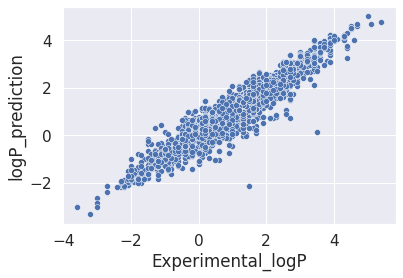

In [ ]:
sns.scatterplot(X1_test['Experimental_logP'],X1_test['logP_prediction'])

In [ ]:
X1_test['relative_percent_difference']=((X1_test['Experimental_logP']-X1_test['logP_prediction'])/(abs(X1_test['logP_prediction'])+abs(X1_test['Experimental_logP'])))*2

In [ ]:
X1_test['|relative_percent_difference|']=abs(((X1_test['Experimental_logP']-X1_test['logP_prediction'])/(abs(X1_test['logP_prediction'])+abs(X1_test['Experimental_logP'])))*2)

In [ ]:
list_rpd=list(X1_test['relative_percent_difference'])
list_prediction_class=[]

In [ ]:
len(list_rpd)

2922

In [ ]:
for i in range(2922):
  if list_rpd[i]==0:
    list_prediction_class.append(1)
  elif list_rpd[i]>= -0.3 and list_rpd[i]<= 0.3:
    list_prediction_class.append(1)
  else:
    list_prediction_class.append(0)

In [ ]:
list_prediction_class.count(1)

1790

In [ ]:
list_prediction_class.count(0)

1132

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Unrecognized location 'upper-left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  after removing the cwd from sys.path.


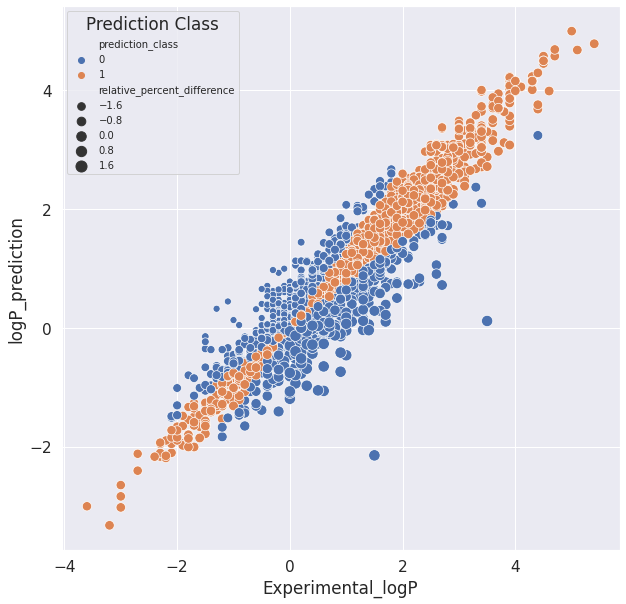

In [ ]:
X1_test['prediction_class']=list_prediction_class
plt.figure(figsize=(10,10))
sns.scatterplot(x='Experimental_logP',y='logP_prediction',data=X1_test,hue='prediction_class',size='relative_percent_difference',sizes=(50,130))
plt.legend(loc='upper-left',prop={'size':10},fancybox=True,title='Prediction Class')
sns.set(font_scale=1)
plt.show()

In [ ]:
X1_test

,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_P_atoms,num_of_S_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms,logP_prediction,Experimental_logP,relative_percent_difference,|relative_percent_difference|,prediction_class
640,9,5,2,0,2,0,0,1,24.72,88.009519,28,3,0.116410,3.5,1.871243,1.871243,0
12526,12,5,2,0,2,0,1,0,29.03,90.034685,30,3,-0.259343,-0.8,-1.020741,1.020741,0
1685,18,7,5,0,0,1,0,1,0.00,138.026999,44,2,2.542138,2.9,0.131515,0.131515,1
14262,13,5,1,0,0,0,4,0,0.00,143.957647,32,4,-0.465595,-0.9,-0.636213,0.636213,0
1260,16,6,4,0,2,0,0,0,24.72,86.084398,36,2,0.859400,1.0,0.151231,0.151231,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14200,19,7,5,0,1,0,0,0,12.03,105.095378,44,2,1.075437,0.9,-0.177618,0.177618,1
8992,11,5,2,0,0,0,1,1,0.00,111.991186,32,3,1.265600,1.1,-0.140007,0.140007,1
13204,7,6,2,1,0,0,0,0,20.23,97.997949,36,4,0.615613,0.4,-0.424597,0.424597,0
7650,19,7,5,0,1,0,0,0,3.24,105.095378,44,2,1.154529,1.6,0.323447,0.323447,0


In [ ]:
bad_predicted_logP=X1_test[X1_test['prediction_class']==0]
bad_predicted_logP

,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_P_atoms,num_of_S_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms,logP_prediction,Experimental_logP,relative_percent_difference,|relative_percent_difference|,prediction_class
640,9,5,2,0,2,0,0,1,24.72,88.009519,28,3,0.116410,3.5,1.871243,1.871243,0
12526,12,5,2,0,2,0,1,0,29.03,90.034685,30,3,-0.259343,-0.8,-1.020741,1.020741,0
14262,13,5,1,0,0,0,4,0,0.00,143.957647,32,4,-0.465595,-0.9,-0.636213,0.636213,0
12204,8,4,1,0,0,0,1,1,0.00,207.889830,26,3,1.204533,1.8,0.396379,0.396379,0
11544,13,6,3,2,1,0,0,0,44.48,89.047678,36,3,0.503808,0.0,-2.000000,2.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,18,6,4,0,1,0,1,0,3.24,105.070736,38,2,0.483224,0.9,0.602615,0.602615,0
5682,10,5,1,2,0,1,1,0,40.46,114.971020,32,4,-0.459467,-0.2,0.786899,0.786899,0
8187,24,8,6,0,2,0,0,0,24.06,116.131349,50,2,1.130368,0.7,-0.470253,0.470253,0
13204,7,6,2,1,0,0,0,0,20.23,97.997949,36,4,0.615613,0.4,-0.424597,0.424597,0


In [ ]:
good_predicted_logP=X1_test[X1_test['prediction_class']==1]
good_predicted_logP
 


,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_P_atoms,num_of_S_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms,logP_prediction,Experimental_logP,relative_percent_difference,|relative_percent_difference|,prediction_class
1685,18,7,5,0,0,1,0,1,0.00,138.026999,44,2,2.542138,2.9,0.131515,0.131515,1
1260,16,6,4,0,2,0,0,0,24.72,86.084398,36,2,0.859400,1.0,0.151231,0.151231,1
7393,16,6,4,1,0,0,0,1,20.23,106.045236,38,2,0.835442,1.1,0.273383,0.273383,1
2824,8,4,1,0,1,0,0,0,12.03,175.937799,28,3,0.755067,0.7,-0.075690,0.075690,1
12417,16,7,4,2,0,0,0,0,18.46,215.964728,44,3,1.183901,1.2,0.013507,0.013507,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7316,17,6,4,1,1,0,0,0,46.25,89.084064,38,2,-0.450818,-0.4,0.119458,0.119458,1
8110,9,5,3,0,0,0,0,0,0.00,197.867974,30,2,2.124782,2.0,-0.060503,0.060503,1
14200,19,7,5,0,1,0,0,0,12.03,105.095378,44,2,1.075437,0.9,-0.177618,0.177618,1
8992,11,5,2,0,0,0,1,1,0.00,111.991186,32,3,1.265600,1.1,-0.140007,0.140007,1


In [ ]:
# Describe bad predicted logP
bad_predicted_logP.describe()

,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_P_atoms,num_of_S_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms,logP_prediction,Experimental_logP,relative_percent_difference,|relative_percent_difference|,prediction_class
count,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.0
mean,14.441696,5.916961,3.287102,0.882509,0.739399,0.117491,0.309187,0.339223,24.922314,114.098323,36.742049,2.629859,0.330473,0.350795,-0.093980,1.005436,0.0
std,4.151971,1.023246,1.289175,0.978719,0.855689,0.377733,0.640364,0.616412,15.906897,33.150154,6.648340,0.859703,0.730288,0.848700,1.195124,0.652201,0.0
min,4.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,79.989279,18.000000,0.000000,-2.148100,-2.100000,-2.000000,0.300454,0.0
25%,11.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.360000,91.982579,32.000000,2.000000,-0.127757,-0.200000,-0.794372,0.434542,0.0
50%,15.000000,6.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,24.225000,106.008850,38.000000,3.000000,0.274630,0.300000,-0.335200,0.737857,0.0
75%,17.000000,7.000000,4.000000,1.000000,1.000000,0.000000,0.000000,1.000000,36.367500,120.318881,44.000000,3.000000,0.778250,0.900000,0.645685,1.790782,0.0
max,26.000000,8.000000,6.000000,6.000000,5.000000,3.000000,6.000000,4.000000,88.460000,347.839643,50.000000,6.000000,3.242767,4.400000,2.000000,2.000000,0.0


In [ ]:
# Describe good predicted logP
good_predicted_logP.describe()

,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_P_atoms,num_of_S_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms,logP_prediction,Experimental_logP,relative_percent_difference,|relative_percent_difference|,prediction_class
count,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.0
mean,14.449721,5.899441,3.739665,0.460894,0.407821,0.240782,0.126816,0.351955,13.977598,134.062394,36.732961,2.159777,1.409834,1.409218,-0.007787,0.105160,1.0
std,4.919075,1.121441,1.737156,0.836146,0.782098,0.607031,0.413720,0.690213,19.486324,53.059762,7.018635,1.212084,1.335951,1.363154,0.133493,0.082561,0.0
min,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,79.982906,12.000000,0.000000,-3.327000,-3.600000,-0.299010,0.000000,1.0
25%,11.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95.061061,32.000000,1.000000,0.794708,0.800000,-0.098207,0.033179,1.0
50%,15.000000,6.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.855000,114.140851,38.000000,2.000000,1.519128,1.500000,-0.004826,0.089994,1.0
75%,18.000000,7.000000,5.000000,1.000000,1.000000,0.000000,0.000000,1.000000,20.230000,157.935234,44.000000,3.000000,2.203531,2.200000,0.080029,0.165611,1.0
max,32.000000,10.000000,10.000000,7.000000,6.000000,4.000000,4.000000,5.000000,119.010000,345.826504,62.000000,7.000000,5.000000,5.400000,0.294734,0.299010,1.0


In [ ]:
X_test.columns

Index(['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms', 'num_of_P_atoms',
       'num_of_S_atoms'],
      dtype='object')

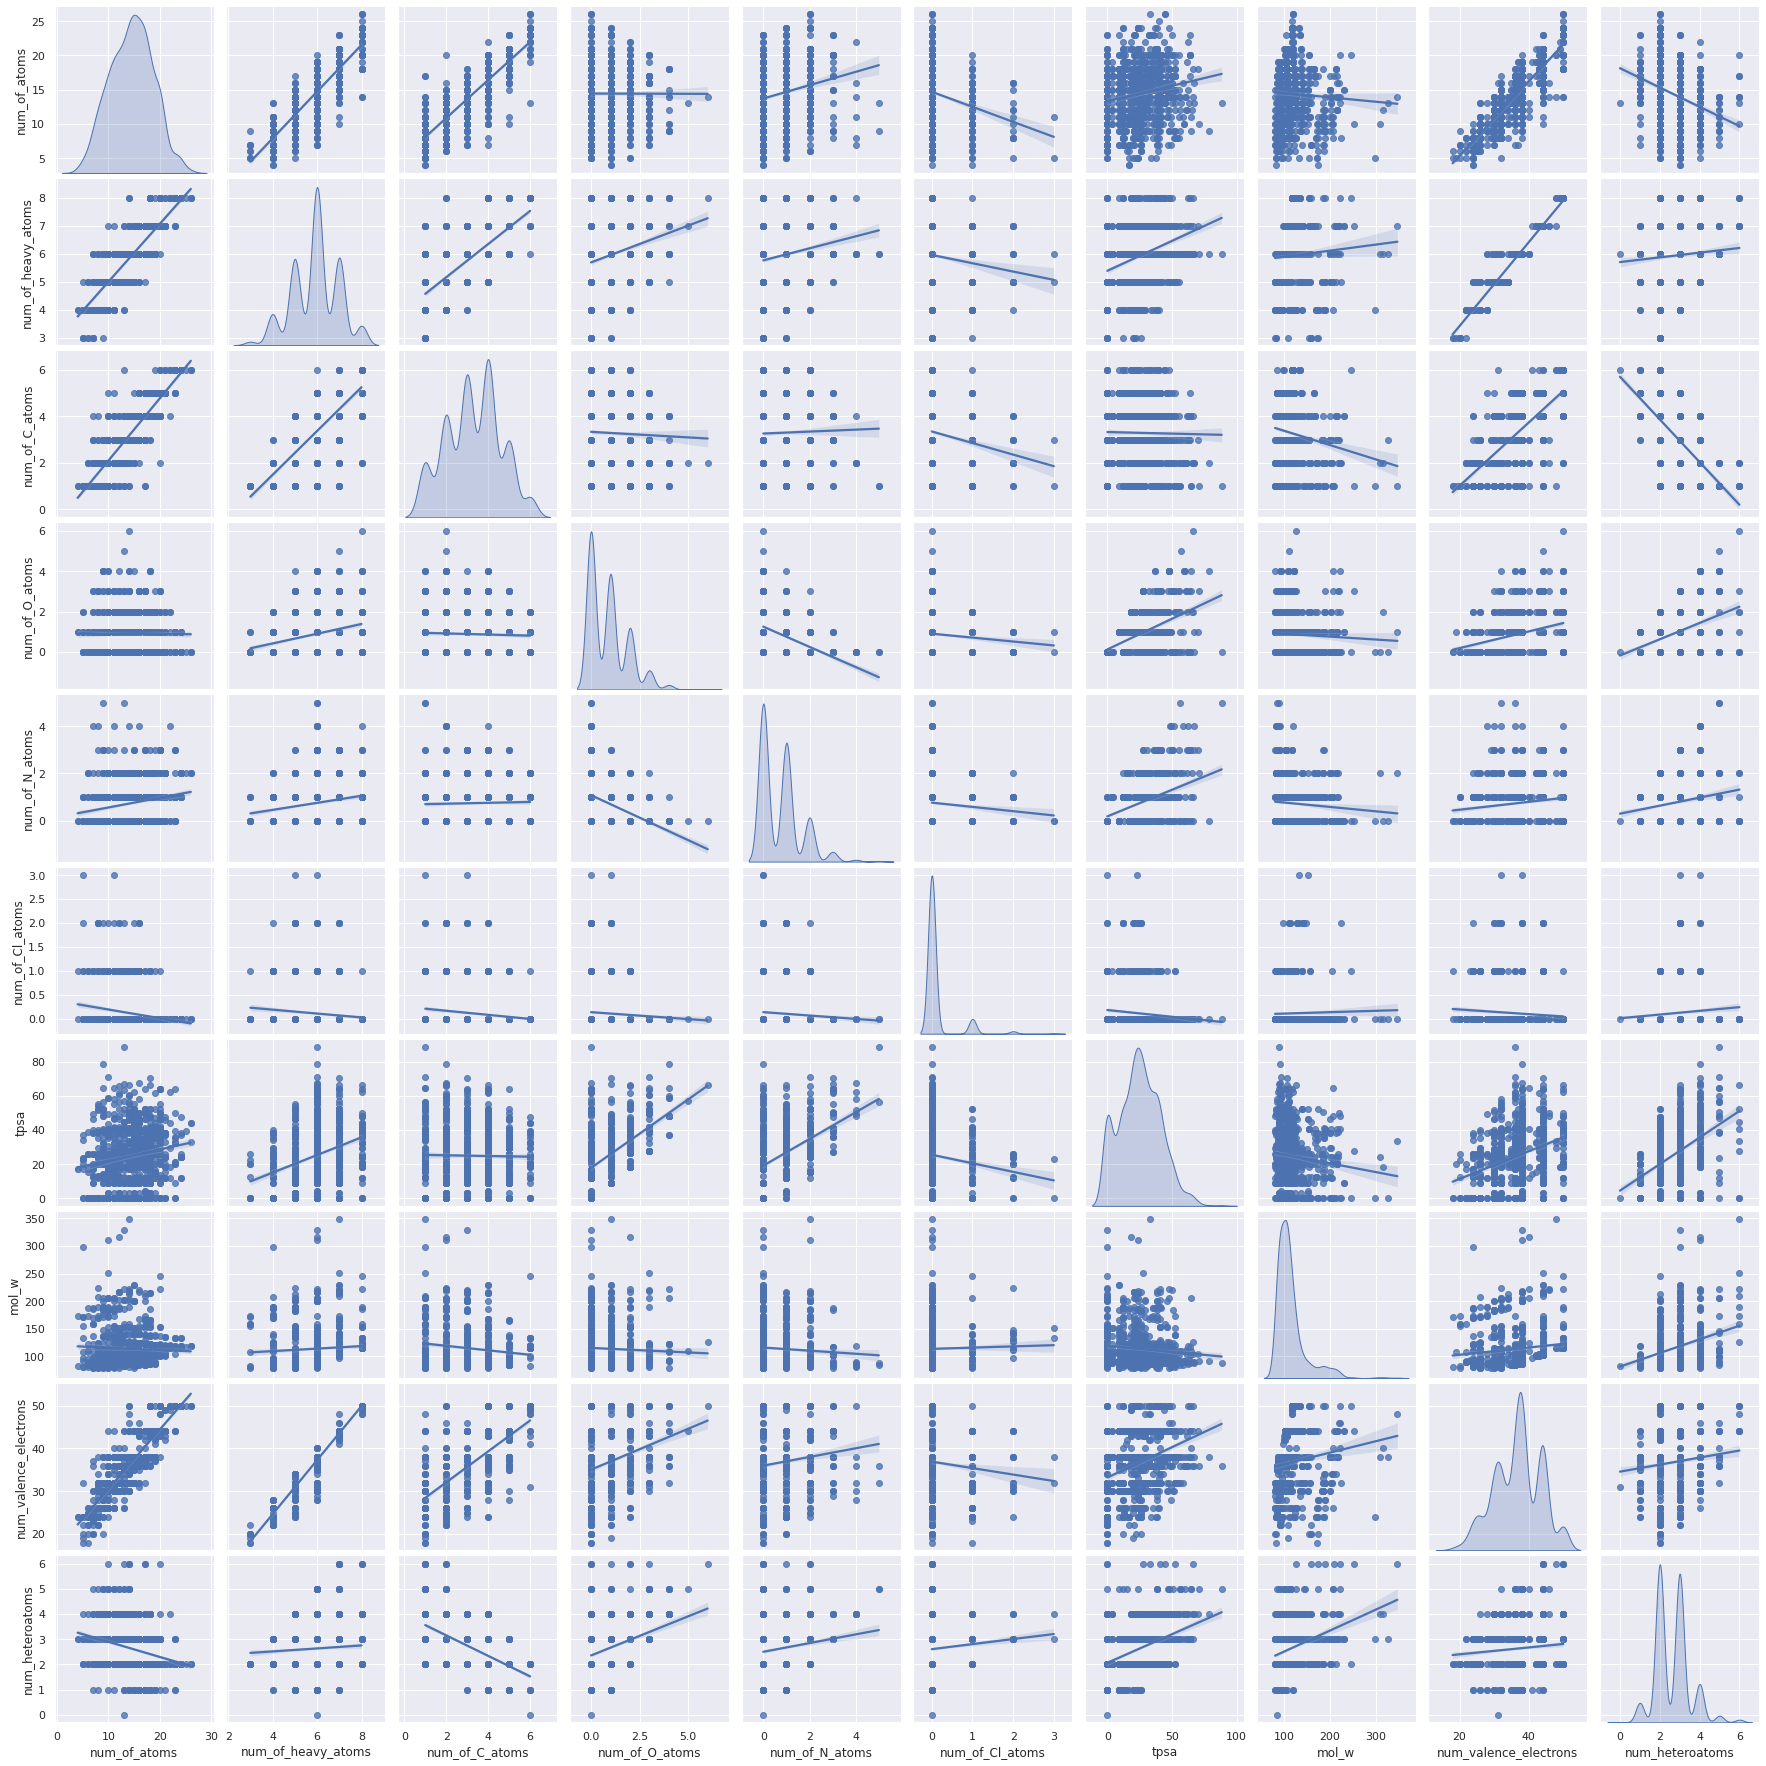

In [ ]:
sns.pairplot(bad_predicted_logP[['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms', 'tpsa', 'mol_w',
       'num_valence_electrons', 'num_heteroatoms']],diag_kind='kde',kind='reg')
plt.show()

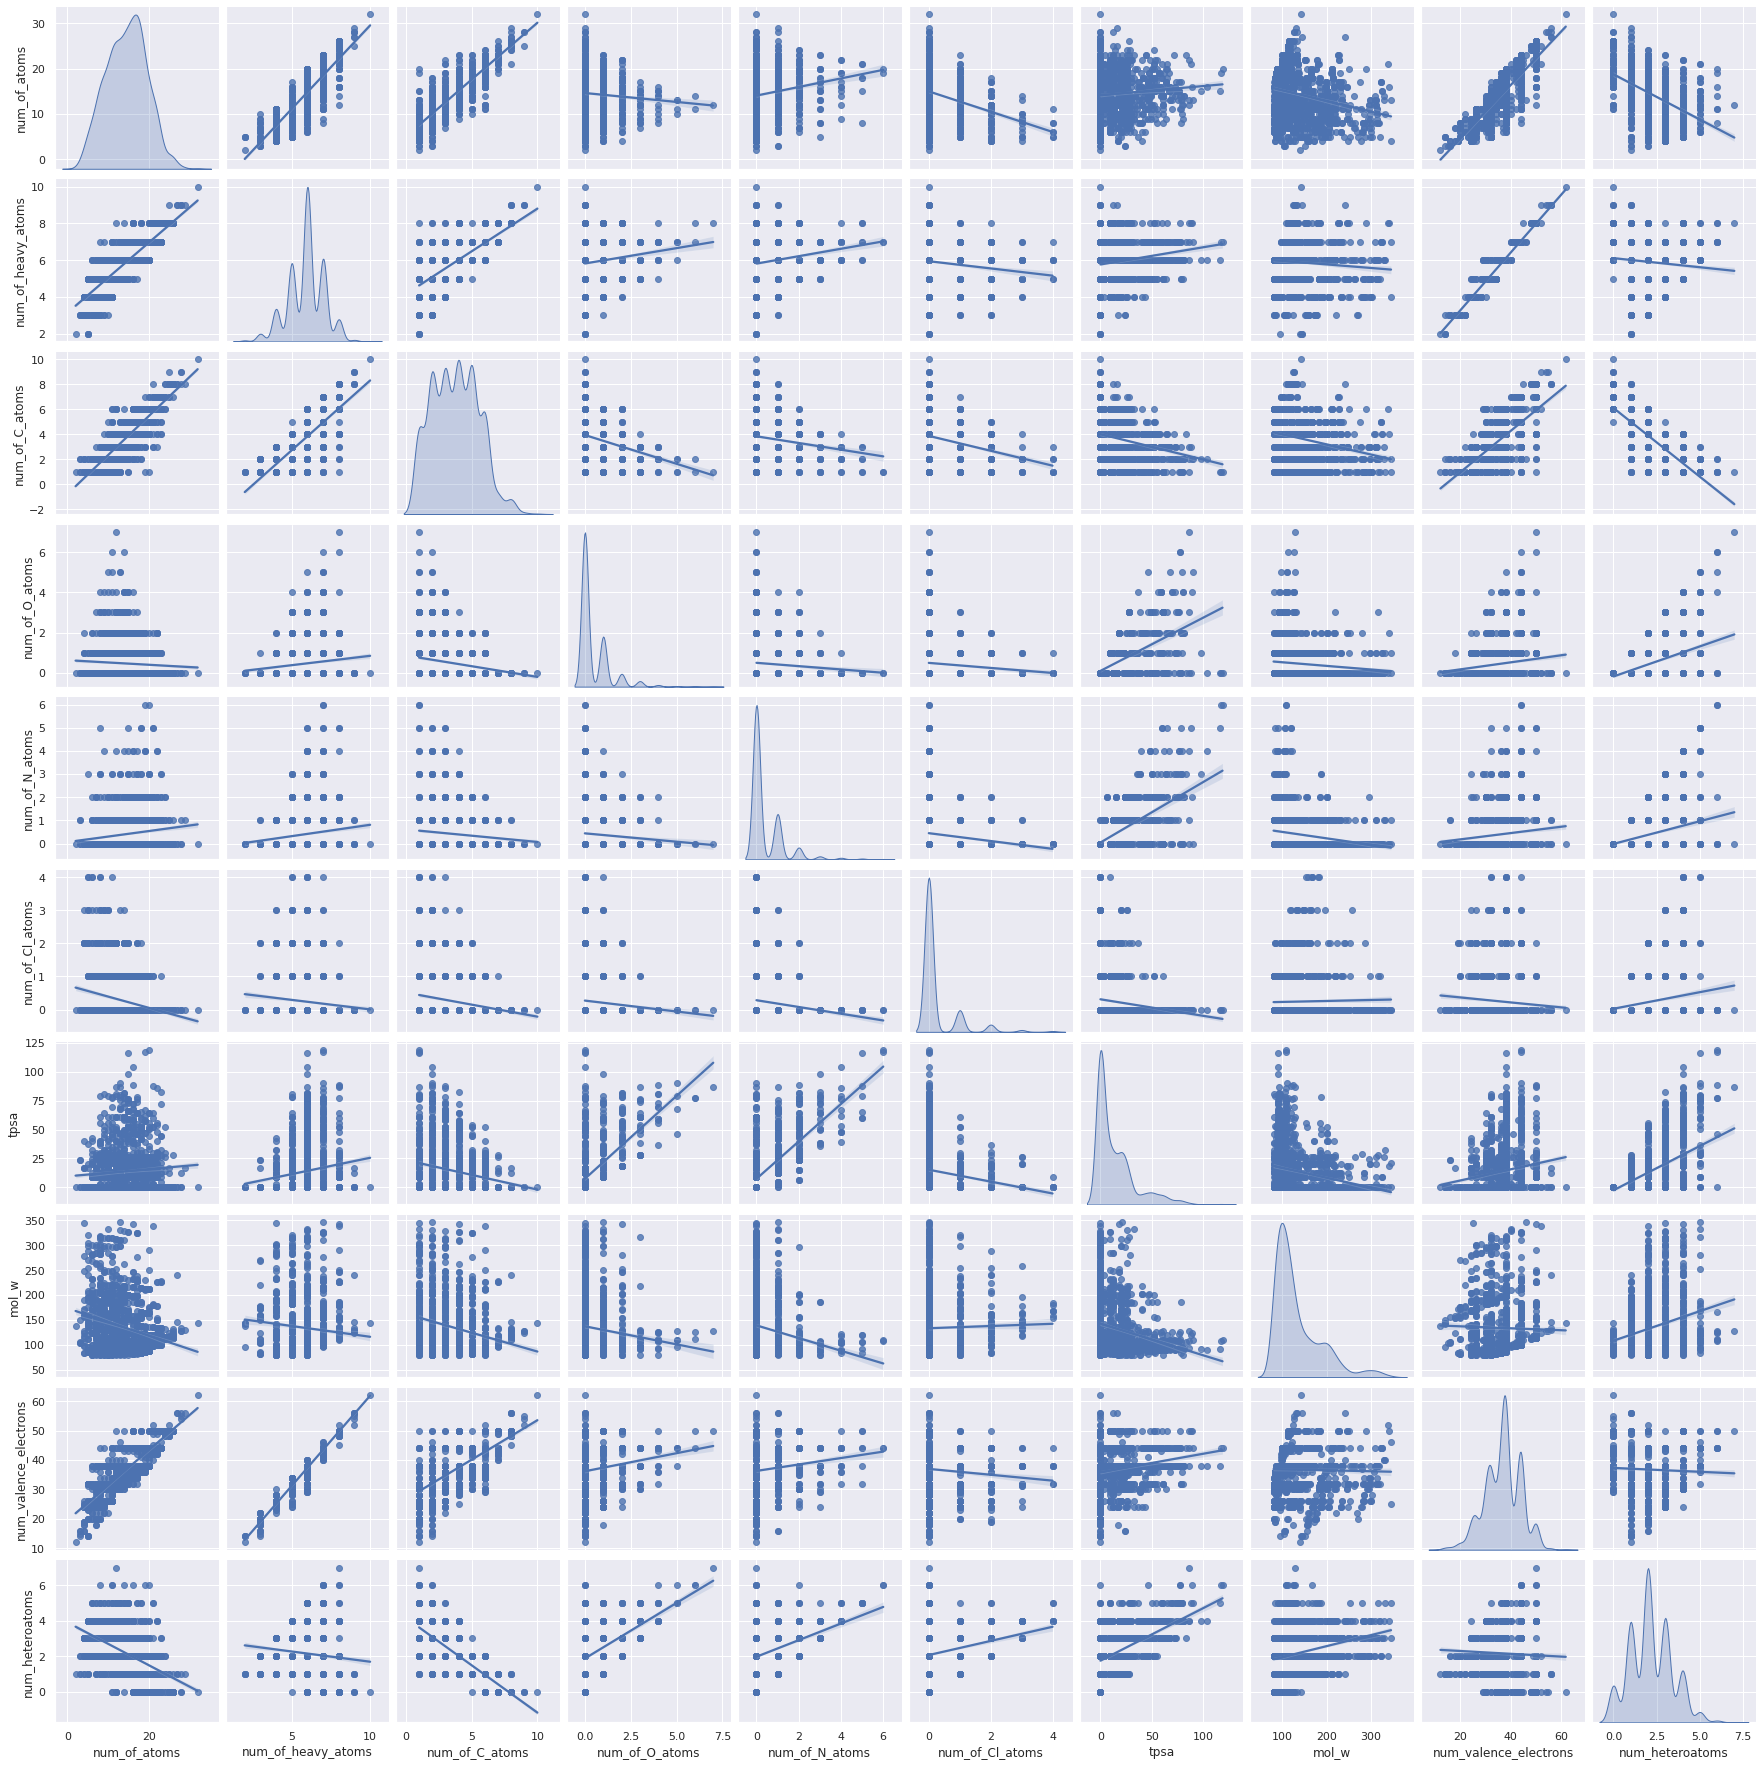

In [ ]:
sns.pairplot(good_predicted_logP[['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms', 'tpsa', 'mol_w',
       'num_valence_electrons', 'num_heteroatoms']],diag_kind='kde',kind='reg')
plt.show()

In [ ]:
indexes_bad_predicted=list(bad_predicted_logP.index)
indexes_good_predicted=list(good_predicted_logP.index)
smiles_for_bad_predicted_df=logP.iloc[indexes_bad_predicted]
smiles_for_good_predicted_df=logP.iloc[indexes_good_predicted]
smiles_for_bad_predicted_df.head(3)

,smiles,logP,mol,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_P_atoms,num_of_S_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms
640,C=NSN=C,3.5,<rdkit.Chem.rdchem.Mol object at 0x7fb488945490>,9,5,2,0,2,0,0,1,24.72,88.009519,28,3
12526,C1CN1PN,-0.8,<rdkit.Chem.rdchem.Mol object at 0x7fb4888b30d0>,12,5,2,0,2,0,1,0,29.03,90.034685,30,3
14262,C(P)(P)(P)P,-0.9,<rdkit.Chem.rdchem.Mol object at 0x7fb488855c10>,13,5,1,0,0,0,4,0,0.00,143.957647,32,4


In [ ]:
bad_predicted_logP['smiles_molecule']=smiles_for_bad_predicted_df['smiles']
good_predicted_logP['smiles_molecule']=smiles_for_good_predicted_df['smiles']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
len(bad_predicted_logP)+len(good_predicted_logP)

2922

In [ ]:
bad_predicted_logP['absolute_error']=abs(bad_predicted_logP['Experimental_logP']-bad_predicted_logP['logP_prediction'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
bad_predicted_logP['prediction-experimental']=bad_predicted_logP['logP_prediction']-bad_predicted_logP['Experimental_logP']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
bad_predicted_logP

,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_P_atoms,num_of_S_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms,logP_prediction,Experimental_logP,relative_percent_difference,|relative_percent_difference|,prediction_class,smiles_molecule,absolute_error,prediction-experimental
640,9,5,2,0,2,0,0,1,24.72,88.009519,28,3,0.116410,3.5,1.871243,1.871243,0,C=NSN=C,3.383590,-3.383590
12526,12,5,2,0,2,0,1,0,29.03,90.034685,30,3,-0.259343,-0.8,-1.020741,1.020741,0,C1CN1PN,0.540657,0.540657
14262,13,5,1,0,0,0,4,0,0.00,143.957647,32,4,-0.465595,-0.9,-0.636213,0.636213,0,C(P)(P)(P)P,0.434405,0.434405
12204,8,4,1,0,0,0,1,1,0.00,207.889830,26,3,1.204533,1.8,0.396379,0.396379,0,[3H]P=S(C)I,0.595467,-0.595467
11544,13,6,3,2,1,0,0,0,44.48,89.047678,36,3,0.503808,0.0,-2.000000,2.000000,0,C=CCOON,0.503808,0.503808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,18,6,4,0,1,0,1,0,3.24,105.070736,38,2,0.483224,0.9,0.602615,0.602615,0,CC(C)N(C)P,0.416776,-0.416776
5682,10,5,1,2,0,1,1,0,40.46,114.971020,32,4,-0.459467,-0.2,0.786899,0.786899,0,C[P+](O)(O)Cl,0.259467,-0.259467
8187,24,8,6,0,2,0,0,0,24.06,116.131349,50,2,1.130368,0.7,-0.470253,0.470253,0,CCCCNCNC,0.430368,0.430368
13204,7,6,2,1,0,0,0,0,20.23,97.997949,36,4,0.615613,0.4,-0.424597,0.424597,0,[C](C(F)(F)F)O,0.215613,0.215613


In [ ]:
bad_predicted_logP_minus=bad_predicted_logP[bad_predicted_logP['prediction-experimental']<0]
bad_predicted_logP_plus=bad_predicted_logP[bad_predicted_logP['prediction-experimental']>0]

In [ ]:
len(bad_predicted_logP_minus)+len(bad_predicted_logP_plus)

1132

In [ ]:
bad_predicted_logP_minus=bad_predicted_logP_minus.sort_values(by='relative_percent_difference',ascending=False)
len(bad_predicted_logP_minus)

523

In [ ]:
bad_predicted_logP_plus=bad_predicted_logP_plus.sort_values(by='relative_percent_difference',ascending=False)
len(bad_predicted_logP_plus)

609

In [ ]:
bad_predicted_logP_minus1=bad_predicted_logP_minus.sort_values(by='absolute_error',ascending=False)
bad_predicted_logP_plus1=bad_predicted_logP_plus.sort_values(by='absolute_error',ascending=False)

In [ ]:
bad_predicted_logP_minus1.head()

,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_P_atoms,num_of_S_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms,logP_prediction,Experimental_logP,relative_percent_difference,|relative_percent_difference|,prediction_class,smiles_molecule,absolute_error,prediction-experimental
13112,9,6,2,4,0,0,0,0,78.41,91.004779,38,4,-2.148100,1.5,2.000000,2.000000,0,COC([O-])([O-])[O-],3.648100,-3.648100
640,9,5,2,0,2,0,0,1,24.72,88.009519,28,3,0.116410,3.5,1.871243,1.871243,0,C=NSN=C,3.383590,-3.383590
12919,10,5,2,0,2,0,0,0,15.60,183.949746,30,3,0.722133,2.7,1.155926,1.155926,0,CN(N=C)I,1.977867,-1.977867
8093,16,6,5,0,1,0,0,0,12.36,84.081324,35,1,0.906767,2.6,0.965695,0.965695,0,[CH2]CCCN=C,1.693233,-1.693233
8927,12,6,2,2,2,0,0,0,65.67,90.042927,36,4,-1.061833,0.6,2.000000,2.000000,0,C(CON=N)O,1.661833,-1.661833


In [ ]:
bad_predicted_logP_plus1.head()

,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_P_atoms,num_of_S_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms,logP_prediction,Experimental_logP,relative_percent_difference,|relative_percent_difference|,prediction_class,smiles_molecule,absolute_error,prediction-experimental
9457,11,6,4,0,1,0,1,0,14.14,98.015412,30,2,0.322121,-1.3,-2.000000,2.000000,0,C1=CC=P[NH+]=C1,1.622121,1.622121
210,7,4,1,2,0,0,0,1,40.13,79.989279,26,3,0.444917,-1.1,-2.000000,2.000000,0,[13CH3]S(=O)[O-],1.544917,1.544917
5060,15,6,4,0,2,0,0,0,26.13,85.077122,36,2,-0.144960,-1.5,-1.647506,1.647506,0,C1C[N-]CCN1,1.355040,1.355040
6047,17,6,5,0,0,0,1,0,0.00,102.059837,36,1,0.974639,-0.3,-2.000000,2.000000,0,CCC=PCC,1.274639,1.274639
10688,17,6,5,0,0,0,1,0,0.00,102.059837,36,1,0.974639,-0.3,-2.000000,2.000000,0,CCCC=PC,1.274639,1.274639


In [ ]:
bad_predicted_logP_minus['mol']=bad_predicted_logP_minus['smiles_molecule'].apply(lambda x: Chem.MolFromSmiles(x))
bad_predicted_logP_plus['mol']=bad_predicted_logP_plus['smiles_molecule'].apply(lambda x: Chem.MolFromSmiles(x))
bad_predicted_logP_minus1['mol']=bad_predicted_logP_minus['smiles_molecule'].apply(lambda x: Chem.MolFromSmiles(x))
bad_predicted_logP_plus1['mol']=bad_predicted_logP_plus['smiles_molecule'].apply(lambda x: Chem.MolFromSmiles(x))

In [ ]:
bad_predicted_logP_minus.to_excel('tabla1_<0.xlsx',index=False)
bad_predicted_logP_plus.to_excel('tabla2_>0.xlsx',index=False)
bad_predicted_logP_minus1.to_excel('tabla3_<0.xlsx',index=False)
bad_predicted_logP_plus1.to_excel('tabla4>0.xlsx',index=False)

/usr/local/lib/python3.7/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:254: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


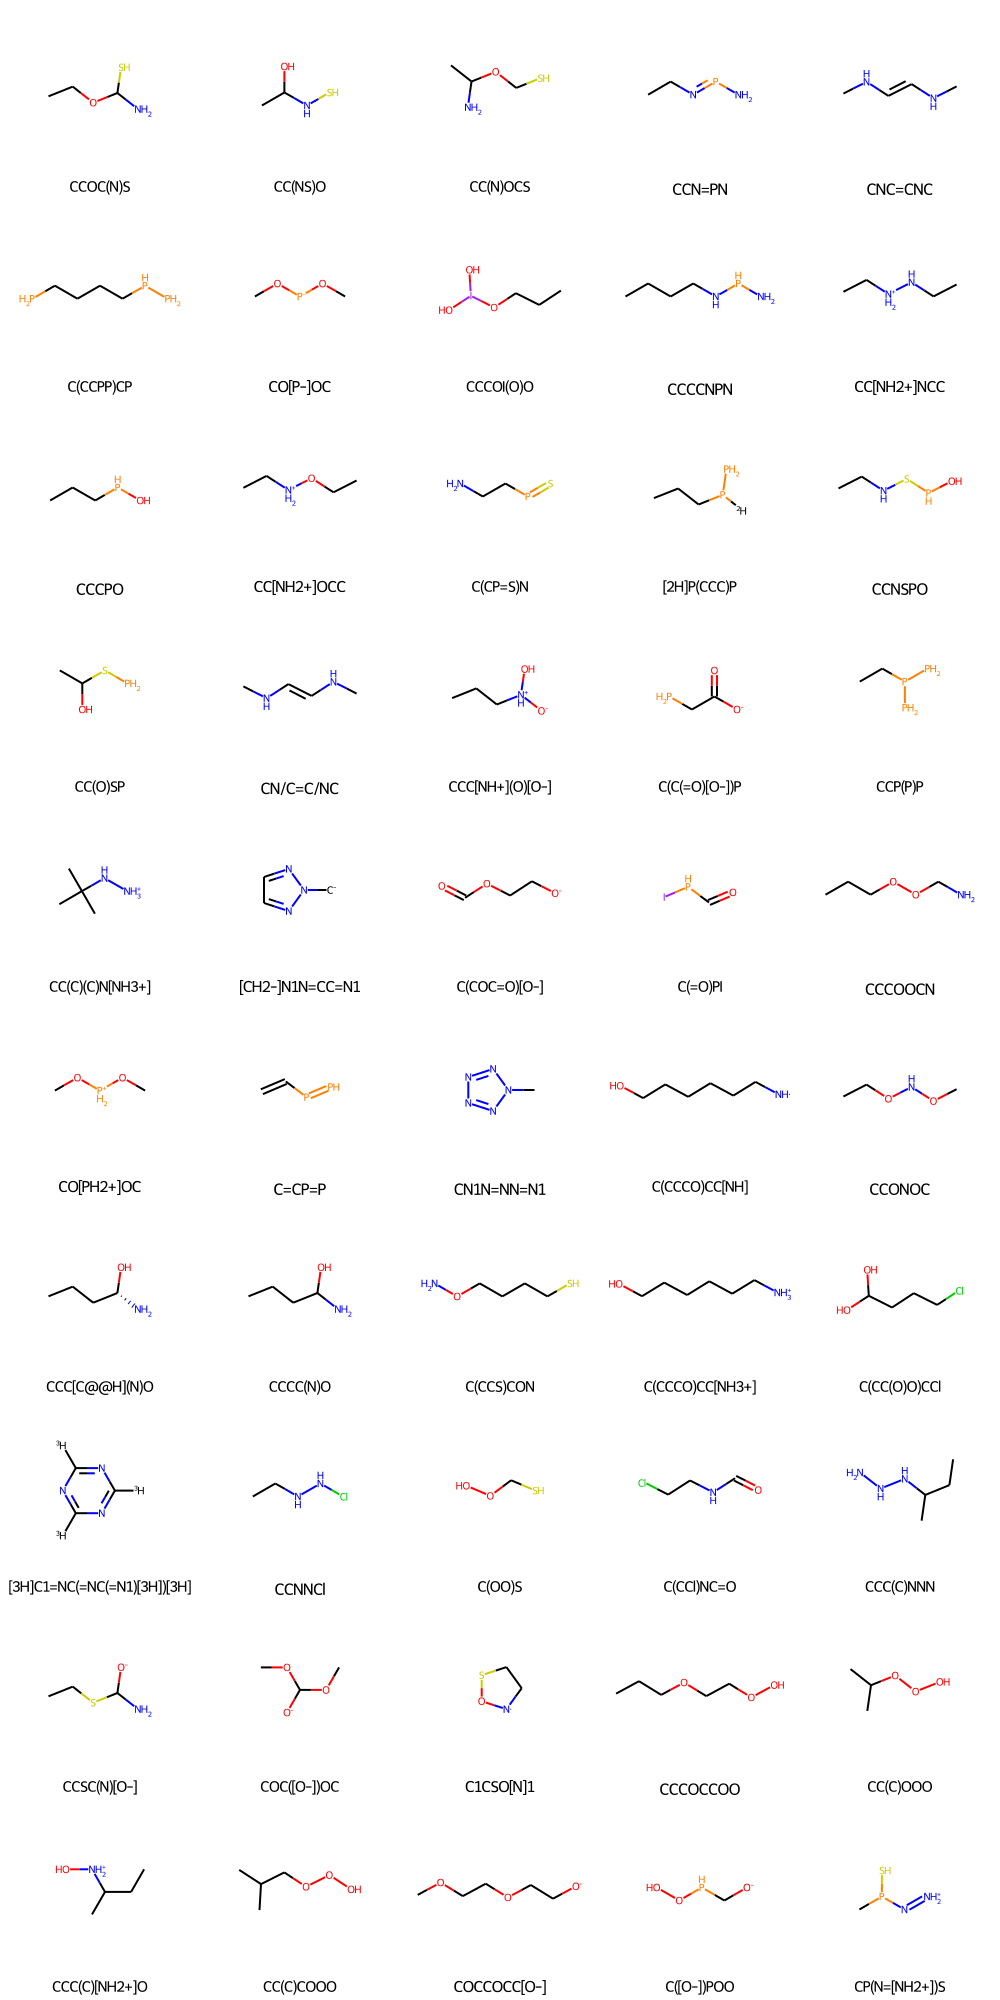

In [ ]:
mol_images2=bad_predicted_logP_minus.mol
Draw.MolsToGridImage(mol_images2, molsPerRow=5, useSVG=True, legends=list(bad_predicted_logP_minus['smiles_molecule']))

/usr/local/lib/python3.7/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:254: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


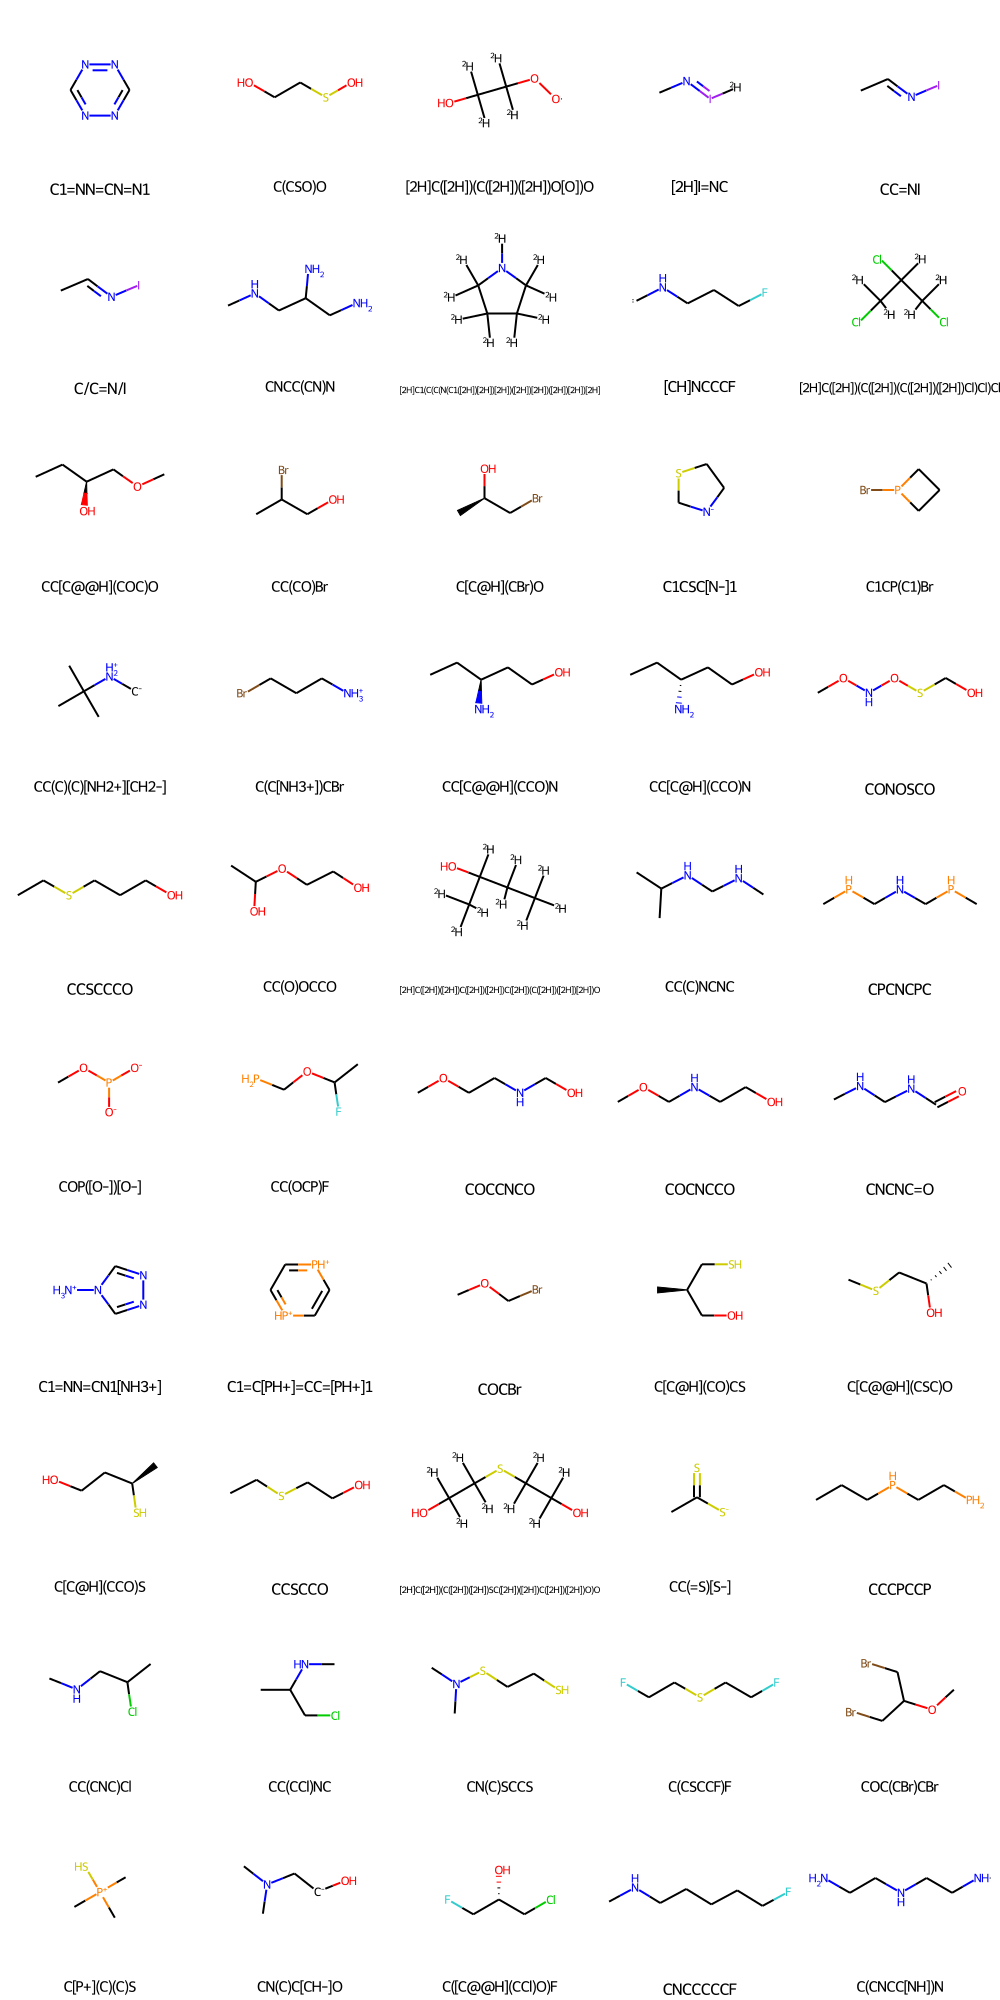

In [ ]:
mol_images3=bad_predicted_logP_plus.mol
Draw.MolsToGridImage(mol_images3, molsPerRow=5, useSVG=True, legends=list(bad_predicted_logP_plus['smiles_molecule']))

In [ ]:
good_predicted_logP['mol']=good_predicted_logP['smiles_molecule'].apply(lambda x: Chem.MolFromSmiles(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
good_predicted_logP.to_excel('good_predicted_logP.xlsx',index=False)

In [ ]:
bad_predicted_logP['mol']=bad_predicted_logP['smiles_molecule'].apply(lambda x: Chem.MolFromSmiles(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
bad_predicted_logP.to_excel('bad_predicted_logP.xlsx',index=False)

In [ ]:
len(bad_predicted_logP)

1132

In [ ]:
X1_test.columns

Index(['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms', 'num_of_P_atoms',
       'num_of_S_atoms', 'tpsa', 'mol_w', 'num_valence_electrons',
       'num_heteroatoms', 'logP_prediction', 'Experimental_logP',
       'relative_percent_difference', '|relative_percent_difference|',
       'prediction_class'],
      dtype='object')

In [ ]:
bad_predicted_logP.columns

Index(['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms', 'num_of_P_atoms',
       'num_of_S_atoms', 'tpsa', 'mol_w', 'num_valence_electrons',
       'num_heteroatoms', 'logP_prediction', 'Experimental_logP',
       'relative_percent_difference', '|relative_percent_difference|',
       'prediction_class', 'smiles_molecule', 'absolute_error',
       'prediction-experimental', 'mol'],
      dtype='object')

In [ ]:
bad_heatmap=bad_predicted_logP.drop(columns=['relative_percent_difference', '|relative_percent_difference|',
       'prediction_class', 'smiles_molecule', 'absolute_error',
       'prediction-experimental', 'mol'])

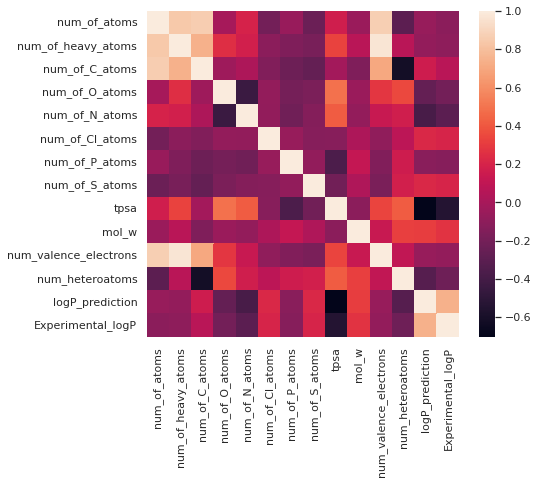

In [ ]:
plt.figure(figsize=(7,6))
sns.heatmap(bad_heatmap.corr())
sns.set(font_scale=1.5)

In [ ]:
good_heatmap=good_predicted_logP.drop(columns=['relative_percent_difference', '|relative_percent_difference|',
       'prediction_class', 'smiles_molecule', 'mol'])

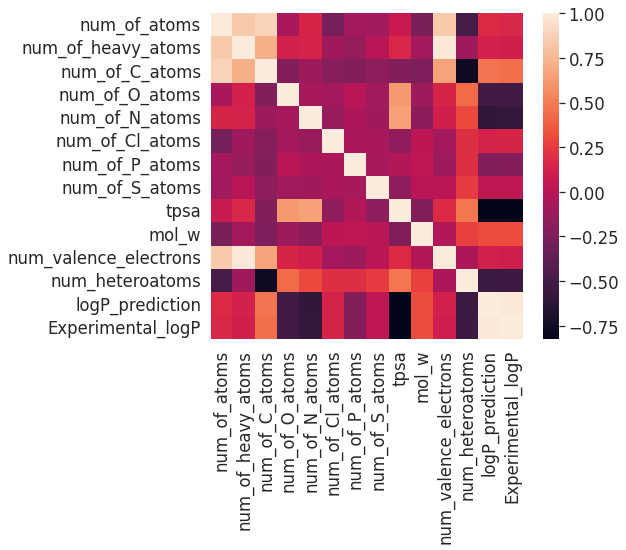

In [ ]:
plt.figure(figsize=(7,6))
sns.heatmap(good_heatmap.corr())
sns.set(font_scale=1.3)